In [1]:
import mpl_scatter_density
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.path import Path
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [2]:
def read_fits (name):
    hdulist = fits.open(name)
    field_data = hdulist[1].data
    header = hdulist[1].header
    hdulist.close()
    return field_data

In [69]:
data = read_fits('/scratch/SMASH_DATA/Field23_allobj_stars.fits.gz')
#data = read_fits('/scratch/SMASH_DATA/SMC_contiguous_catalogue/combined_fields_allobj_largeG_02_error.fits')

In [8]:
def phi12_rotmat(alpha,delta):
    '''
    Converts coordinates (alpha,delta) to ones defined by a rotation matrix R_phi12_radec, applied on the original coordinates

    Critical: All angles must be in degrees
    '''
    R_phi12_radec = np.array([[ 0.04842439,  0.30207466, -0.95205356],
                              [-0.99433193,  0.10490506, -0.01728974],
                              [ 0.09465244,  0.9474945 ,  0.30544245]])
    
    #R_LB_radec = np.array([[ 0.04842439,  0.30207466, -0.95205356],
    #   [-0.99433193,  0.10490506, -0.01728974],
    #   [ 0.09465244,  0.9474945 ,  0.30544245]])
    
    vec_radec = np.array([np.cos(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(alpha*np.pi/180.)*np.cos(delta*np.pi/180.),np.sin(delta*np.pi/180.)])

    vec_phi12 = np.zeros(np.shape(vec_radec))
    
    vec_phi12[0] = np.sum(R_phi12_radec[0][i]*vec_radec[i] for i in range(3))
    vec_phi12[1] = np.sum(R_phi12_radec[1][i]*vec_radec[i] for i in range(3))
    vec_phi12[2] = np.sum(R_phi12_radec[2][i]*vec_radec[i] for i in range(3))
    
    vec_phi12 = vec_phi12.T

    vec_phi12 = np.dot(R_phi12_radec,vec_radec).T

    phi1 = np.arctan2(vec_phi12[:,1],vec_phi12[:,0])*180./np.pi
    phi2 = np.arcsin(vec_phi12[:,2])*180./np.pi


    return [phi1,phi2]

In [70]:
ms_l, ms_b = phi12_rotmat(data['RA'], data['DEC'])

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [6]:
# Respectively u,g,r,i,z,Y. Ex: A_u = R_u*EBV_SFD98 ; u0 = u - A_u
extinction_coeff_decam = np.array([3.9631, 3.1863, 2.1401, 1.5690, 1.1957, 1.0476])

In [53]:
EBV = 0.04
correction_g = EBV * 3.1863
corregtion_i = EBV * 1.5690
correction_gi = correction_g - corregtion_i
young_vertexs_dered = np.array([(-1,14),(-1,20),(-0.2,22.8),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)])
young_vertexs = np.array([young_vertexs_dered.T[0]+correction_gi, young_vertexs_dered.T[1]+correction_g]).T
young_path = Path(young_vertexs)
old_vertexs_dered = np.array([(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)])
old_vertexs = np.array([old_vertexs_dered.T[0]+correction_gi, old_vertexs_dered.T[1]+correction_g]).T
old_path = Path(old_vertexs)
msto_vertex_coord = np.array([(0.0,24.0), (0.0,21.5), (0.5,21.5), (0.5,24.0)])
msto_vertexs = np.array([msto_vertex_coord.T[0], msto_vertex_coord.T[1]]).T
msto_path = Path(msto_vertexs)
#print(young_vertexs)

In [71]:
colours = data['G'] - data['I']
cmd_points = np.array([colours, data['G']])
young_mask = young_path.contains_points(cmd_points.T)
old_mask = old_path.contains_points(cmd_points.T)
msto_mask = msto_path.contains_points(cmd_points.T)

In [44]:
def density_plot_creation(x, y, fig_name, resolution):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':18})
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='magma', dpi=resolution, norm=LogNorm(vmin=1))
    ax.set_xlabel('MS$_L$ (deg)')
    ax.set_ylabel('MS$_B$ (deg)')
    ax.invert_xaxis()
    #ax.set_xlim(-12, -18)
    #ax.set_ylim(-15, -8)
    fig.colorbar(density, label='Counts per pixel')
    plt.show()
    fig.savefig(fig_name, bbox_inches = 'tight')
    plt.close()

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:614: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(*ax.dataLim.intervalx)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:615: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*ax.dataLim.intervaly)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:301: RuntimeWarning: invalid value encountered in log1

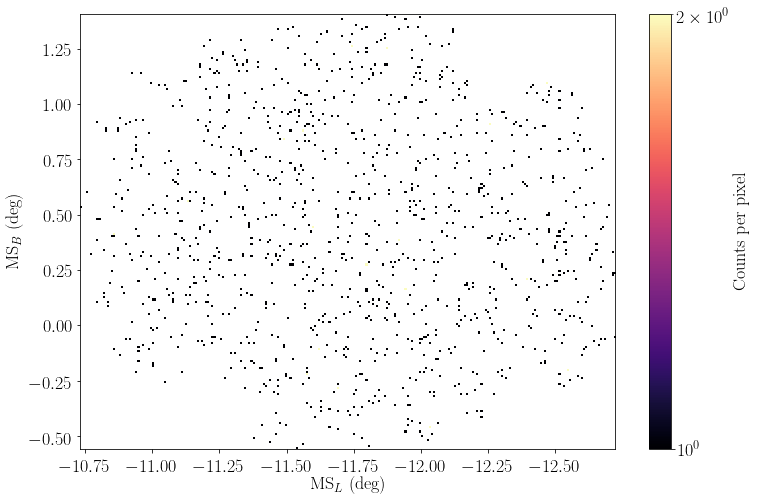

In [72]:
fig_name = 'Field23_msto.pdf'
resolution = 40
density_plot_creation(ms_l[msto_mask], ms_b[msto_mask], fig_name, resolution)

# LMC RC map

In [109]:
data_rc = read_fits('/scratch/SMASH_DATA/LMC_contiguous_catalogues/LMCbody_RC_uniq_final.fits')

In [110]:
ms_l_rc, ms_b_rc = phi12_rotmat(data_rc['RA'], data_rc['DEC'])

/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:614: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(*ax.dataLim.intervalx)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:615: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(*ax.dataLim.intervaly)
/user/HS128/pm00518/virtualenvs/venv/lib/python3.5/site-packages/matplotlib/colorbar.py:301: RuntimeWarning: invalid value encountered in log1

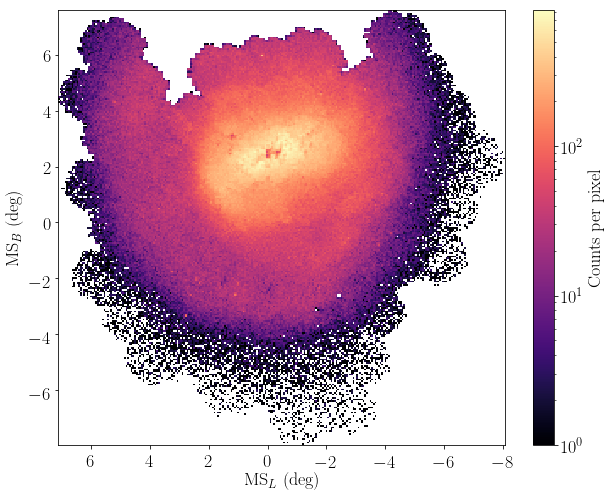

In [111]:
fig_name = 'LMC_RC_map.pdf'
density_plot_creation(ms_l_rc, ms_b_rc, fig_name)

# CMD zone plot

In [73]:
colours = data['G'] - data['I']
colours = colours[colours==colours]
mag = data['G']
colours_temp = data['G'] - data['I']
mag = mag[colours_temp == colours_temp]
no_i_phot = np.asarray(colours < -10)
print(colours[~no_i_phot].shape, mag[~no_i_phot].shape)

(32981426,) (32981426,)


In [95]:
def CMD_zone_plot(colour, mag, resolution, vertex_list):
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':18})
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='scatter_density')
    density = ax.scatter_density(colour, mag, cmap='magma', dpi=resolution, norm=LogNorm(vmin=1))
    fig.colorbar(density, label='Counts per pixel')
    
    patches = []
    edge_colours = np.array(['blue', 'red'])
    polygon = Polygon(vertex_list[0], edgecolor=edge_colours[0], fill=False, linewidth=2.)
    ax.add_patch(polygon)
    polygon2 = Polygon(vertex_list[1], edgecolor=edge_colours[1], fill=False, linewidth=2.)
    ax.add_patch(polygon2)
    #ax.invert_yaxis()
    ax.set_xlabel('$g-i$')
    ax.set_ylabel('$g$')
    ax.set_xlim((-2,4))
    ax.set_ylim((26.5, 13.5))
    
    #plt.show()
    plt.savefig('CMD_zones.pdf', bbox_inches = 'tight')
    plt.close()

In [112]:
resolution = 100
vertexs_list = [young_vertexs, old_vertexs]
CMD_zone_plot(colours[~no_i_phot], mag[~no_i_phot], resolution, vertexs_list)

# Age distinction

First, we will plot a CMD with the different isochrones to know where we have to make the cuts.

In [9]:
def CMD_isochrone_plot(colour, mag, resolution, isochrones_list, isochrones_labels):
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':18})
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='scatter_density')
    density = ax.scatter_density(colour, mag, cmap='magma', dpi=resolution, norm=LogNorm(vmin=1))
    fig.colorbar(density, label='Counts per pixel')
    
    
    for isochrone, label in zip(isochrones_list, isochrones_labels):
        ax.plot(isochrone[0], isochrone[1], linewidth = 3.0, label = label)
#     patches = []
#     edge_colours = np.array(['blue', 'red'])
#     polygon = Polygon(vertex_list[0], edgecolor=edge_colours[0], fill=False, linewidth=2.)
#     ax.add_patch(polygon)
#     polygon2 = Polygon(vertex_list[1], edgecolor=edge_colours[1], fill=False, linewidth=2.)
#     ax.add_patch(polygon2)
    #ax.invert_yaxis()
    ax.set_xlabel('$g-i$')
    ax.set_ylabel('$g$')
    ax.set_xlim((-2,4))
    ax.set_ylim((26.5, 13.5))
    plt.legend()
    
    #plt.show()
    plt.savefig('CMD_isochrones.pdf', bbox_inches = 'tight')
    plt.close()

In [27]:
isochrone1_data = [np.loadtxt('/scratch/Isochrones/50Myr_05FeH.cmd').T[10],np.loadtxt('/scratch/Isochrones/50Myr_05FeH.cmd').T[12]]
isochrone2_data = [np.loadtxt('/scratch/Isochrones/100Myr_05FeH.cmd').T[10],np.loadtxt('/scratch/Isochrones/100Myr_05FeH.cmd').T[12]]
isochrone3_data = np.loadtxt('/scratch/Isochrones/300Myr_05FeH.cmd').T[10,12]
isochrone4_data = np.loadtxt('/scratch/Isochrones/500Myr_08FeH.cmd').T[10,12]
isochrone5_data = np.loadtxt('/scratch/Isochrones/1Gyr_1FeH.cmd').T[10,12]
isochrone6_data = np.loadtxt('/scratch/Isochrones/3Gyr_15FeH.cmd').T[10,12]
print(isochrone1_data, isochrone2_data)
isochrone_mags = [isochrone1_data, isochrone2_data, isochrone3_data, isochrone4_data, isochrone5_data, isochrone6_data]

[array([ 1.2945919e+01,  1.2905836e+01,  1.2844121e+01,  1.2812559e+01,
        1.2771139e+01,  1.2702656e+01,  1.2633090e+01,  1.2557033e+01,
        1.2473429e+01,  1.2386322e+01,  1.2295768e+01,  1.2201557e+01,
        1.2103640e+01,  1.2023321e+01,  1.1948896e+01,  1.1873668e+01,
        1.1797543e+01,  1.1720594e+01,  1.1642587e+01,  1.1563546e+01,
        1.1478378e+01,  1.1387249e+01,  1.1295547e+01,  1.1203173e+01,
        1.1110146e+01,  1.1022222e+01,  1.0934102e+01,  1.0846818e+01,
        1.0759317e+01,  1.0713379e+01,  1.0705045e+01,  1.0696973e+01,
        1.0689203e+01,  1.0681745e+01,  1.0674645e+01,  1.0667933e+01,
        1.0661051e+01,  1.0654401e+01,  1.0620007e+01,  1.0573545e+01,
        1.0424161e+01,  1.0287229e+01,  1.0037750e+01,  9.8405350e+00,
        9.6333540e+00,  9.4089690e+00,  9.1888430e+00,  8.9687740e+00,
        8.7317460e+00,  8.4802460e+00,  8.2206900e+00,  7.9589150e+00,
        7.7086110e+00,  7.4770760e+00,  7.2604690e+00,  7.0627720e+00,
     

In [22]:
print(isochrone_mags)

[12.10364  12.534151 12.76341  12.974567 13.059275 12.370683]
